In [1]:
from tensorflow import keras
import tensorflow as tf 
# Common imports
import os
import matplotlib.image as mpimg
import itertools
import seaborn as sns

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import itertools

from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import learning_rate_schedule
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.util.tf_export import keras_export

import scipy
import numpy as np

In [2]:
def parameter(n):
    alpha = []
    for i in range(n):
    	alpha.append(4.8 + 0.005**(i+1)) #0.8 
    return alpha

def parameter1(n):
    alpha = []
    for i in range(n):
        alpha.append(1.4 - 0.005**(i+1)) # 0.8
    beta = []
    for i in range(n):
        beta.append(0.9 - 0.005**(i+1)) #0.8
    return alpha, beta

def summation(n):
    summ = 0
    alpha = parameter(n)
    for i in range(n):
        summ += alpha[i]
    return summ

def Fisher(n):
    FIM = []
    alpha = parameter(n)
    for i in range(n):
        Row = []
        for j in range(n):
            if i == j: 
                Row.append(special.polygamma(1, alpha[i]) - special.polygamma(1, summation(n)))
            else:
                Row.append(- special.polygamma(1, summation(n)))
        FIM.append(Row)
    FIM = numpy.array(FIM)
    FIM = numpy.linalg.inv(FIM)
    return FIM

def Fisher2(n):
    FIM = []
    for i in range(n):
        Zero = []
        for j in range(n):
            Zero.append(0)
        FIM.append(Zero)
    alpha, beta = parameter1(n)
    for i in range(0,n,2):
        FIM[i][i] = special.polygamma(1, alpha[i]) - special.polygamma(1, alpha[i]+beta[i])
        FIM[i+1][i] = - special.polygamma(1, alpha[i]+beta[i])
        FIM[i][i+1] = - special.polygamma(1, alpha[i]+beta[i])
        FIM[i+1][i+1] = special.polygamma(1, beta[i]) - special.polygamma(1, alpha[i]+beta[i])
    FIM = numpy.array(FIM)
    FIM = numpy.linalg.inv(FIM)
    return FIM

In [3]:
def Riemann_Liouville_derivative(gradient, alpha, kappa, variable):
    RL_gradient = np.array([])
    for i in range(len(gradient)):
        RL_gradient.append(
            1/scipy.special.gamma(len(gradient)-alpha)*scipy.misc.derivative(
                scipy.integrate.quad(
                    lambda tau: variable[i]/(tau-variable[i])**(alpha-kappa+1),0,variable[i])
                , n = kappa)
            )
    return RL_gradient

In [4]:
def Caputo_derivative(gradient, alpha, kappa, variable):
    C_gradient = np.array([])
    for i in range(len(gradient)):
        C_gradient.append(
            1/scipy.special.gamma(len(gradient)-alpha)*scipy.integrate.quad(
                lambda tau: scipy.misc.derivative(variable[i], n = kappa)/(tau-variable[i])**(alpha-kappa+1),0,variable[i])
            )
    return C_gradient

In [5]:
def Grunwald_Letnikov_derivative(gradient, h, alpha, kappa, variable):
    GL_gradient = np.array([])
    for i in range(len(gradient)):
        summ = 0
        for j in range(len(gradient)):
            summ += (-1)**k * scipy.special.gamma(alpha+1)*variable[j]/(scipy.special.gamma(kappa+1)*scipy.special.gamma(alpha-kappa+1))
        GL_gradient.append(
            1/h**alpha * summ
        ) 
    return GL_gradient

In [6]:
@keras_export("keras.optimizers.SGD")
class SGD(optimizer_v2.OptimizerV2):

  _HAS_AGGREGATE_GRAD = True

  def __init__(self,
               learning_rate=0.01,
               momentum=0.0,
               nesterov=False,
               name="SGD",
               **kwargs):
    super(SGD, self).__init__(name, **kwargs)
    self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))
    self._set_hyper("decay", self._initial_decay)

    self._momentum = False
    if isinstance(momentum, tf.Tensor) or callable(momentum) or momentum > 0:
      self._momentum = True
    if isinstance(momentum, (int, float)) and (momentum < 0 or momentum > 1):
      raise ValueError(f"`momentum` must be between [0, 1]. Received: "
                       f"momentum={momentum} (of type {type(momentum)}).")
    self._set_hyper("momentum", momentum)

    self.nesterov = nesterov

  def _create_slots(self, var_list):
    if self._momentum:
      for var in var_list:
        self.add_slot(var, "momentum")

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(SGD, self)._prepare_local(var_device, var_dtype, apply_state)
    apply_state[(var_device, var_dtype)]["momentum"] = tf.identity(
        self._get_hyper("momentum", var_dtype))

  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    if self._momentum:
      momentum_var = self.get_slot(var, "momentum")
      return tf.raw_ops.ResourceApplyKerasMomentum(
          var=var.handle,
          accum=momentum_var.handle,
          lr=coefficients["lr_t"],
          grad=grad,
          momentum=coefficients["momentum"],
          use_locking=self._use_locking,
          use_nesterov=self.nesterov)
    else:
      return tf.raw_ops.ResourceApplyGradientDescent(
          var=var.handle,
          alpha=coefficients["lr_t"],
          delta=grad,
          use_locking=self._use_locking)

  def _resource_apply_sparse_duplicate_indices(self, grad, var, indices,
                                               **kwargs):
    if self._momentum:
      return super(SGD, self)._resource_apply_sparse_duplicate_indices(
          grad, var, indices, **kwargs)
    else:
      var_device, var_dtype = var.device, var.dtype.base_dtype
      coefficients = (kwargs.get("apply_state", {}).get((var_device, var_dtype))
                      or self._fallback_apply_state(var_device, var_dtype))

      return tf.raw_ops.ResourceScatterAdd(
          resource=var.handle,
          indices=indices,
          updates=-grad * coefficients["lr_t"])

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    # This method is only needed for momentum optimization.
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    momentum_var = self.get_slot(var, "momentum")
    return tf.raw_ops.ResourceSparseApplyKerasMomentum(
        var=var.handle,
        accum=momentum_var.handle,
        lr=coefficients["lr_t"],
        grad=grad,
        indices=indices,
        momentum=coefficients["momentum"],
        use_locking=self._use_locking,
        use_nesterov=self.nesterov)

  def get_config(self):
    config = super(SGD, self).get_config()
    config.update({
        "learning_rate": self._serialize_hyperparameter("learning_rate"),
        "decay": self._initial_decay,
        "momentum": self._serialize_hyperparameter("momentum"),
        "nesterov": self.nesterov,
    })
    return config

In [7]:
class CFGD(optimizer_v2.OptimizerV2):
  _HAS_AGGREGATE_GRAD = True

  def __init__(self,
               learning_rate=0.01,
               momentum=0.0,
               nesterov=False,
               name="CFGD",
               **kwargs):
    super(CFGD, self).__init__(name, **kwargs)
    self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))
    self._set_hyper("decay", self._initial_decay)

    self._momentum = False
    if isinstance(momentum, tf.Tensor) or callable(momentum) or momentum > 0:
      self._momentum = True
    if isinstance(momentum, (int, float)) and (momentum < 0 or momentum > 1):
      raise ValueError(f"`momentum` must be between [0, 1]. Received: "
                       f"momentum={momentum} (of type {type(momentum)}).")
    self._set_hyper("momentum", momentum)

    self.nesterov = nesterov

  def _create_slots(self, var_list):
    if self._momentum:
      for var in var_list:
        self.add_slot(var, "momentum")

  def _prepare_local(self, var_device, var_dtype, apply_state):
    super(CFGD, self)._prepare_local(var_device, var_dtype, apply_state)
    apply_state[(var_device, var_dtype)]["momentum"] = tf.identity(
        self._get_hyper("momentum", var_dtype))

  def _resource_apply_dense(self, grad, var, apply_state=None):
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    if self._momentum:
      momentum_var = self.get_slot(var, "momentum")
      return tf.raw_ops.ResourceApplyKerasMomentum(
          var=var.handle,
          accum=momentum_var.handle,
          lr=coefficients["lr_t"],
          grad=grad,
          momentum=coefficients["momentum"],
          use_locking=self._use_locking,
          use_nesterov=self.nesterov)
    else:
      return tf.raw_ops.ResourceApplyGradientDescent(
          var=var.handle,
          alpha=coefficients["lr_t"],
          delta=grad,
          use_locking=self._use_locking)

  def _resource_apply_sparse_duplicate_indices(self, grad, var, indices,
                                               **kwargs):
    if self._momentum:
      return super(CFGD, self)._resource_apply_sparse_duplicate_indices(
          grad, var, indices, **kwargs)
    else:
      var_device, var_dtype = var.device, var.dtype.base_dtype
      coefficients = (kwargs.get("apply_state", {}).get((var_device, var_dtype))
                      or self._fallback_apply_state(var_device, var_dtype))

      return tf.raw_ops.ResourceScatterAdd(
          resource=var.handle,
          indices=indices,
          updates=np.dot(Fisher(len(grad)),Caputo_derivative(grad, 0.5, 0.5, var).transpose()) * coefficients["lr_t"])
          #updates=-Caputo_derivative(grad, 8.8, 4, var) * coefficients["lr_t"])
          #updates=-grad * coefficients["lr_t"])

  def _resource_apply_sparse(self, grad, var, indices, apply_state=None):
    # This method is only needed for momentum optimization.
    var_device, var_dtype = var.device, var.dtype.base_dtype
    coefficients = ((apply_state or {}).get((var_device, var_dtype))
                    or self._fallback_apply_state(var_device, var_dtype))

    momentum_var = self.get_slot(var, "momentum")
    return tf.raw_ops.ResourceSparseApplyKerasMomentum(
        var=var.handle,
        accum=momentum_var.handle,
        lr=coefficients["lr_t"],
        grad=grad,
        indices=indices,
        momentum=coefficients["momentum"],
        use_locking=self._use_locking,
        use_nesterov=self.nesterov)

  def get_config(self):
    config = super(CFGD, self).get_config()
    config.update({
        "learning_rate": self._serialize_hyperparameter("learning_rate"),
        "decay": self._initial_decay,
        "momentum": self._serialize_hyperparameter("momentum"),
        "nesterov": self.nesterov,
    })
    return config

In [8]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [9]:
y_train = y_train.flatten()
y_test = y_test.flatten()

C:\Users\pliak\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[[Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')]]

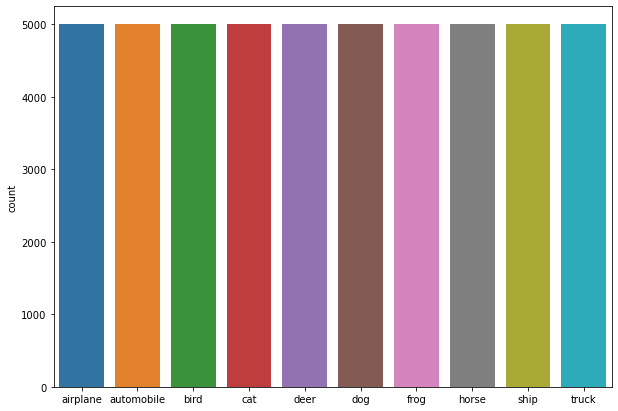

In [10]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,7))
p = sns.countplot(y_train.flatten())
p.set(xticklabels=classes)

In [11]:
input_shape = (32, 32, 3)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_test=x_test / 255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

In [12]:
batch_size = 32
num_classes = 10
epochs = 20

In [13]:
model = Sequential([
    Conv2D(32, 3, padding='same', input_shape=x_train.shape[1:], activation='relu'),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

optimizer = CFGD(learning_rate = 0.004, momentum = 0.94, nesterov = True)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=batch_size,
                    epochs=epochs, validation_data = (x_test, y_test))

Epoch 1/20
1563/1563 [==============================] - 100s 63ms/step - loss: 1.7287 - accuracy: 0.3609 - val_loss: 1.3105 - val_accuracy: 0.5233
Epoch 2/20
1563/1563 [==============================] - 94s 60ms/step - loss: 1.2956 - accuracy: 0.5338 - val_loss: 1.1045 - val_accuracy: 0.6097
Epoch 3/20
1563/1563 [==============================] - 99s 63ms/step - loss: 1.1157 - accuracy: 0.6010 - val_loss: 1.0063 - val_accuracy: 0.6492
Epoch 4/20
1563/1563 [==============================] - 100s 64ms/step - loss: 0.9946 - accuracy: 0.6474 - val_loss: 0.8964 - val_accuracy: 0.6930
Epoch 5/20
1563/1563 [==============================] - 96s 62ms/step - loss: 0.9123 - accuracy: 0.6769 - val_loss: 0.8226 - val_accuracy: 0.7133
Epoch 6/20
1563/1563 [==============================] - 102s 65ms/step - loss: 0.8433 - accuracy: 0.7031 - val_loss: 0.7895 - val_accuracy: 0.7221
Epoch 7/20
1563/1563 [==============================] - 98s 63ms/step - loss: 0.7904 - accuracy: 0.7211 - val_loss: 0.723

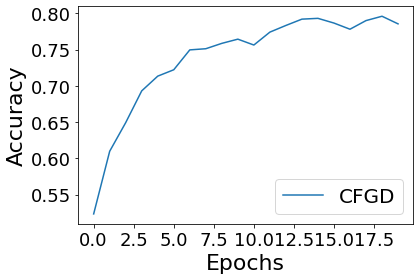

In [14]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs',fontsize = 22)
plt.ylabel('Accuracy',fontsize = 22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(['CFGD'], prop = {"size":20})
plt.show()